<h1>Emotion Detection</h1>

Humans use their facial features or expressions to convey how they feel, such as a person may smile when happy and scowl when angry. Historically, computer vision research has focussed on analyzing and learning these facial features to recognize emotions.
However, these facial features are not universal and vary extensively across cultures and situations

This project uses the <a href="http://sunai.uoc.edu/emotic/download.html">EMOTIC dataset</a> and follows the methodology as introduced in the paper <a href="https://arxiv.org/pdf/2003.13401.pdf">'Context based emotion recognition using EMOTIC dataset'</a>.

In [ ]:
# Linking Google drive to use preprocessed data
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
#/content/drive/My Drive//

Mounted at /content/drive


# I. Prepare places pretrained model

In [ ]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

--2024-06-06 17:59:21--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘./places/resnet50_places365.pth.tar’

./places/resnet50_p 100%[===================>]  92.76M  16.0MB/s    in 7.7s    

2024-06-06 17:59:29 (12.1 MB/s) - ‘./places/resnet50_places365.pth.tar’ saved [97270159/97270159]



In [ ]:
# Saving the model weights to use ahead in the notebook
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import os

# the architecture to use
arch = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


# II. General imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

print ('completed cell')

completed cell


# III. Emotic classes

## Emotic Model

In [ ]:
class Emotic(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_context_features, num_body_features):
    super(Emotic,self).__init__()
    self.num_context_features = num_context_features
    self.num_body_features = num_body_features
    self.fc1 = nn.Linear((self.num_context_features + num_body_features), 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.d1 = nn.Dropout(p=0.5)
    self.fc_cat = nn.Linear(256, 26)
    self.fc_cont = nn.Linear(256, 3)
    self.relu = nn.ReLU()


  def forward(self, x_context, x_body):
    context_features = x_context.view(-1, self.num_context_features)
    body_features = x_body.view(-1, self.num_body_features)
    fuse_features = torch.cat((context_features, body_features), 1)
    fuse_out = self.fc1(fuse_features)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.relu(fuse_out)
    fuse_out = self.d1(fuse_out)
    cat_out = self.fc_cat(fuse_out)
    cont_out = self.fc_cont(fuse_out)
    return cat_out, cont_out

print ('completed cell')

completed cell


## Emotic Dataset

In [ ]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, y_cat, y_cont, transform, context_norm, body_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std

  def __len__(self):
    return len(self.y_cat)

  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


## Emotic Losses

In [ ]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cuda')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)

  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum()

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


In [ ]:
class DiscreteAccuracy(nn.Module):
    ''' Class to measure accuracy between categorical emotion predictions and labels. '''
    def __init__(self, device=torch.device('cuda')):
        super(DiscreteAccuracy, self).__init__()
        self.device = device

    def forward(self, pred, target):
        _, pred_labels = torch.max(pred, dim=1)
        _, target_labels = torch.max(target, dim=1)
        correct = (pred_labels == target_labels).sum().item()
        total = target.size(0)
        accuracy = correct / total
        return accuracy

print('completed cell')


completed cell


In [ ]:
class ContinuousAccuracy(nn.Module):
    ''' Class to measure accuracy between continuous emotion dimension predictions and labels. '''
    def __init__(self, margin=1):
        super(ContinuousAccuracy, self).__init__()
        self.margin = margin

    def forward(self, pred, target):
        difference = torch.abs(pred - target)
        correct = (difference < self.margin).sum().item()
        total = target.numel()
        accuracy = correct / total
        return accuracy

print('completed cell')


completed cell


# IV. Load preprocessed data

In [ ]:
# Change data_src variable as per your drive
data_src = '/content/drive/My Drive/emoticallyEmotionally'


# Load training preprocessed data
train_context = np.load(os.path.join(data_src,'emotic_pre','train_context_arr.npy'))
train_body = np.load(os.path.join(data_src,'emotic_pre','train_body_arr.npy'))
train_cat = np.load(os.path.join(data_src,'emotic_pre','train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'emotic_pre','train_cont_arr.npy'))


# Load validation preprocessed data
val_context = np.load(os.path.join(data_src,'emotic_pre','val_context_arr.npy'))
val_body = np.load(os.path.join(data_src,'emotic_pre','val_body_arr.npy'))
val_cat = np.load(os.path.join(data_src,'emotic_pre','val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'emotic_pre','val_cont_arr.npy'))


# Load testing preprocessed data
test_context = np.load(os.path.join(data_src,'emotic_pre','test_context_arr.npy'))
test_body = np.load(os.path.join(data_src,'emotic_pre','test_body_arr.npy'))
test_cat = np.load(os.path.join(data_src,'emotic_pre','test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'emotic_pre','test_cont_arr.npy'))

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

print ('train ', 'context ', train_context.shape, 'body', train_body.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print ('val ', 'context ', val_context.shape, 'body', val_body.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print ('test ', 'context ', test_context.shape, 'body', test_body.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print ('completed cell')

train  context  (15918, 224, 224, 3) body (15918, 128, 128, 3) cat  (15918, 26) cont (15918, 3)
val  context  (2378, 224, 224, 3) body (2378, 128, 128, 3) cat  (2378, 26) cont (2378, 3)
test  context  (5292, 224, 224, 3) body (5292, 128, 128, 3) cat  (5292, 26) cont (5292, 3)
completed cell


In [ ]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]


train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_body, train_cat, train_cont, \
                                  train_transform, context_norm, body_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_cat, val_cont, \
                                test_transform, context_norm, body_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_cat, test_cont, \
                                 test_transform, context_norm, body_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  612 val loader  92 test 204
completed cell


# V. Prepare emotic model

In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet18(pretrained=True)

emotic_model = Emotic(list(model_context.children())[-1].in_features, list(model_body.children())[-1].in_features)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))


# print (summary(model_context, (3,224,224), device="cpu"))
# print (summary(model_body, (3,128,128), device="cpu"))

print ('completed cell')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]

completed cell


## Prepare optimizer

In [ ]:
for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_body.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_SL1 = ContinuousLoss_SL1()

discrete_accuracy = DiscreteAccuracy(device=torch.device('cuda'))
# pred_discrete = torch.randn(32, 26).to('cuda')  # Example predictions
# target_discrete = torch.randint(0, 2, (32, 26)).float().to('cuda')  # Example targets
# accuracy = discrete_accuracy(pred_discrete, target_discrete)
# print('Categorical accuracy:', accuracy)

# Example usage for ContinuousAccuracy
continuous_accuracy = ContinuousAccuracy(margin=1)
# pred_continuous = torch.randn(32, 26)  # Example predictions
# target_continuous = torch.randn(32, 26)  # Example targets
# accuracy = continuous_accuracy(pred_continuous, target_continuous)
# print('Continuous accuracy:', accuracy)


print ('completed cell')

completed cell


# VI. Train model

In [ ]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, discrete_accuracy, continuous_accuracy, cat_loss_param=0.5, cont_loss_param=0.5):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()

  train_accuracy = list()
  val_accuracy = list()

  model_context, model_body, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0
    running_accuracy = 0.0

    emotic_model.to(device)
    model_context.to(device)
    model_body.to(device)

    emotic_model.train()
    model_context.train()
    model_body.train()

    for images_context, images_body, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      images_body = images_body.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)
      pred_body = model_body(images_body)

      pred_cat, pred_cont = emotic_model(pred_context, pred_body)
      cat_loss_batch = disc_loss(pred_cat, labels_cat)
      cat_accuracy_batch = discrete_accuracy(pred_cat, labels_cat)

      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      cont_accuracy_batch = continuous_accuracy(pred_cont*10, labels_cont*10)

      loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
      accuracy = (cat_loss_param * cat_accuracy_batch ) + (cont_loss_param * cont_accuracy_batch)

      running_loss += loss.item()
      running_accuracy += accuracy
      loss.backward()
      opt.step()

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f  training accuracy = %.4f' %(e, running_loss, running_accuracy))
    train_loss.append(running_loss)
    train_accuracy.append(running_accuracy)


    running_loss = 0.0
    running_accuracy = 0.0
    emotic_model.eval()
    model_context.eval()
    model_body.eval()

    with torch.no_grad():
      for images_context, images_body, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        images_body = images_body.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)
        pred_body = model_body(images_body)

        pred_cat, pred_cont = emotic_model(pred_context, pred_body)
        cat_loss_batch = disc_loss(pred_cat, labels_cat)
        cat_accuracy_batch = discrete_accuracy(pred_cat, labels_cat)

        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        cont_accuracy_batch = continuous_accuracy(pred_cont*10, labels_cont*10)

        loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
        accuracy = (cat_loss_param * cat_accuracy_batch ) + (cont_loss_param * cont_accuracy_batch)

        running_loss += loss.item()
        running_accuracy += accuracy

      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f validation accuracy = /%.4f' %(e, running_loss, running_accuracy))
    val_loss.append(running_loss)
    val_accuracy.append(running_accuracy)

    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        model_body.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic1.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context1.pth'))
        torch.save(model_body, os.path.join(model_path, 'model_body1.pth'))

  print ('completed training')

  f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train'])
  ax2.legend(['val'])

  f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_accuracy)),train_accuracy, color='Blue')
  ax2.plot(range(0,len(val_accuracy)),val_accuracy, color='Red')
  ax1.legend(['train'])
  ax2.legend(['val'])

print ('completed cell')

completed cell


epoch = 0 training loss = 49169.8196  training accuracy = 163.7051
epoch = 0 validation loss = 4472.8400 validation accuracy = /27.4316
saving model at epoch e = 0
epoch = 1 training loss = 32616.3133  training accuracy = 204.9359
epoch = 1 validation loss = 4263.3021 validation accuracy = /30.0726
saving model at epoch e = 1
epoch = 2 training loss = 31081.2717  training accuracy = 213.2436
epoch = 2 validation loss = 4093.0745 validation accuracy = /29.9188
saving model at epoch e = 2
epoch = 3 training loss = 30128.7289  training accuracy = 219.1667
epoch = 3 validation loss = 4053.5316 validation accuracy = /31.6656
saving model at epoch e = 3
epoch = 4 training loss = 29551.3643  training accuracy = 220.1667
epoch = 4 validation loss = 3882.4972 validation accuracy = /31.6667
saving model at epoch e = 4
epoch = 5 training loss = 29072.5019  training accuracy = 223.4038
epoch = 5 validation loss = 3788.9219 validation accuracy = /32.6827
saving model at epoch e = 5
epoch = 6 traini

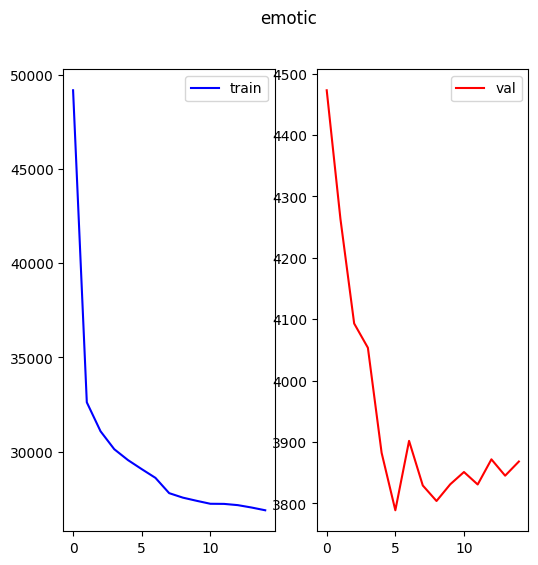

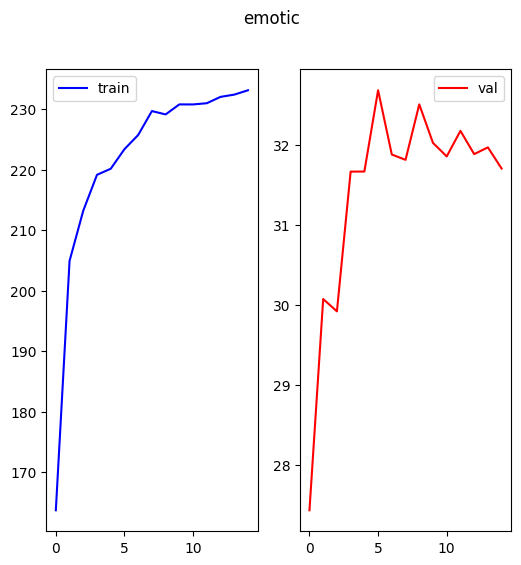

In [ ]:
train_emotic(15, './models', opt, scheduler, [model_context, model_body, emotic_model], disc_loss, cont_loss_SL1, discrete_accuracy, continuous_accuracy)

# VII. Test model

In [ ]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [ ]:
def test_data(models, device, data_loader, num_images):
    model_context, model_body, emotic_model = models
    cat_preds = np.zeros((num_images, 26))
    cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        emotic_model.eval()
        indx = 0
        print ('starting testing')
        for images_context, images_body, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            pred_cat, pred_cont = emotic_model(pred_context, pred_body)

            cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cat.shape[0]

    cat_preds = cat_preds.transpose()
    cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (ap_mean, vad_mean)
    return ap_mean, vad_mean

print ('completed cell')

completed cell


In [ ]:
model_context = torch.load('./models/model_context1.pth')
model_body = torch.load('./models/model_body1.pth')
emotic_model = torch.load('./models/model_emotic1.pth')

print ('completed cell')

completed cell


In [ ]:
val_ap, val_vad = test_data([model_context, model_body, emotic_model], device, val_loader, val_dataset.__len__())
test_ap, test_vad = test_data([model_context, model_body, emotic_model], device, test_loader, test_dataset.__len__())

print ('validation Mean average precision=%.4f Mean VAD MAE=%.4f' %(val_ap, val_vad))
print ('testing Mean average precision=%.4f Mean VAD MAE=%.4f' %(test_ap, test_vad))

starting testing
completed testing
ap [0.4281782  0.276683   0.27475166 0.961686   0.23971216 0.8481081
 0.29506797 0.42746145 0.2231705  0.197155   0.0621414  0.9806725
 0.26857933 0.8218094  0.14987735 0.08704264 0.827995   0.22114383
 0.31735158 0.5012819  0.25400352 0.10439768 0.24187028 0.17188212
 0.4006013  0.12796293] (26,) 0.3734841
vad [0.67200154 0.8206629  0.90247524] (3,) 0.7983799
0.3734841 0.7983799
starting testing
completed testing
ap [0.3272353  0.11816512 0.1845673  0.5807045  0.08269894 0.8241208
 0.14545688 0.2675994  0.18594809 0.16510743 0.01761538 0.8608368
 0.16971827 0.7333315  0.11774749 0.06613454 0.65681463 0.09542712
 0.25681442 0.4484841  0.20966496 0.07243672 0.21932535 0.09953011
 0.1317364  0.09703484] (26,) 0.27439448
vad [0.9292933  1.0301896  0.85516965] (3,) 0.93821746
0.27439448 0.93821746
validation Mean average precision=0.3735 Mean VAD MAE=0.7984
testing Mean average precision=0.2744 Mean VAD MAE=0.9382


In [ ]:
cat_labels = scipy.io.loadmat('./cat_labels.mat')
cat_preds = scipy.io.loadmat('./cat_preds.mat')
cat_preds = cat_preds['cat_preds']
cat_labels = cat_labels['cat_labels']
print (cat_preds.shape, cat_labels.shape)

#thesholds calculation for inference
thresholds = get_thresholds(cat_preds, cat_labels)
print (thresholds, thresholds.shape)

print ('completed cell')

(26, 5292) (26, 5292)
[0.12667945 0.39924297 0.20386359 0.21380141 0.29090795 0.1499719
 0.23713574 0.10933332 0.07446253 0.08181304 0.15729834 0.4064441
 0.08619356 0.18389034 0.13559404 0.1557423  0.23414138 0.3376865
 0.12577145 0.1058828  0.2683152  0.15420958 0.3045631  0.11341298
 0.10213088 0.1002817 ] (26,)
completed cell


# VIII. Average Precision computation using <a href="https://1drv.ms/u/s!AkYHbdGNmIVCgbYZB_dY3wuWJou_5A?e=jcsZUj">author's script</a>

In [ ]:
!apt install octave

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aglfn default-jre-headless epstool fonts-droid-fallback fonts-freefont-otf fonts-noto-mono
  fonts-urw-base35 ghostscript gnuplot-data gnuplot-qt gsfonts imagemagick-6-common info
  install-info libamd2 libauthen-sasl-perl libbtf1 libcamd2 libccolamd2 libcholmod3 libclone-perl
  libcolamd2 libcombblas1.16.0 libcxsparse3 libdata-dump-perl libemf1 libencode-locale-perl
  libevdev2 libfftw3-double3 libfftw3-long3 libfftw3-mpi3 libfftw3-single3 libfile-listing-perl
  libfltk-gl1.3 libfltk1.3 libfont-afm-perl libglpk40 libglu1-mesa libgraphicsmagick++-q16-12
  libgraphicsmagick-q16-3 libgs9 libgs9-common libgudev-1.0-0 libhdf5-openmpi-103-1
  libhtml-form-perl libhtml-format-perl libhtml-parser-perl libhtml-tagset-perl libhtml-tree-perl
  libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl libhttp-message-perl
  libhttp-negotiate-perl

In [ ]:
%%writefile eval.m

gt = load('./cat_labels.mat')
gt = gt.cat_labels

pred = load('./cat_preds.mat')
pred = pred.cat_preds

categories{1} = 'Affection';
categories{2} = 'Anger';
categories{3} = 'Annoyance';
categories{4} = 'Anticipation';
categories{5} = 'Aversion';
categories{6} = 'Confidence';
categories{7} = 'Disapproval';
categories{8} = 'Disconnection';
categories{9} = 'Disquietment';
categories{10} = 'Doubt/Confusion';
categories{11} = 'Embarrassment';
categories{12} = 'Engagement';
categories{13} = 'Esteem';
categories{14} = 'Excitement';
categories{15} = 'Fatigue';
categories{16} = 'Fear';
categories{17} = 'Happiness';
categories{18} = 'Pain';
categories{19} = 'Peace';
categories{20} = 'Pleasure';
categories{21} = 'Sadness';
categories{22} = 'Sensitivity';
categories{23} = 'Suffering';
categories{24} = 'Surprise';
categories{25} = 'Sympathy';
categories{26} = 'Yearning';


for c = 1:length(categories)
  confidence = pred(c,:)';
  testClass = gt(c,:)';
  confidence = double(confidence);

  S = rand('state');
  rand('state',0);
  confidence = confidence + rand(size(confidence))*10^(-10);
  rand('state',S)

  [S,j] = sort(-confidence);
  C = testClass(j);
  n = length(C);

  REL = sum(C);
  if n>0
    RETREL = cumsum(C);
    RET    = (1:n)';
  else
    RETREL = 0;
    RET    = 1;
  end

  precision = 100*RETREL ./ RET;
  recall    = 100*RETREL  / REL;
  th = -S;

  % compute AP
  mrec=[0 ; recall ; 100];
  mpre=[0 ; precision ; 0];
  for i=numel(mpre)-1:-1:1
    mpre(i)=max(mpre(i),mpre(i+1));
  end
  i=find(mrec(2:end)~=mrec(1:end-1))+1;
  averagePrecision=sum((mrec(i)-mrec(i-1)).*mpre(i))/100;
  ap_list(c)  = averagePrecision
end

display('#######################################')

display('Average precision of predictions');
for c = 1:length(categories)
    sp = '............................';
    cat = strcat(categories{c}, sp);
    cat = cat(1:18);
    display(cat);
    display(ap_list(c));
end

Writing eval.m


In [ ]:
!octave -W eval.m

Streaming output truncated to the last 5000 lines.
   2.6624e-02   5.4919e-02   2.7068e-04   5.2645e-02   5.9781e-02   5.9923e-02
  -1.6357e-02   2.1611e-02   5.7764e-02   2.3971e-02   1.9962e-02   1.8276e-02
   9.2112e-03   2.1210e-02   1.4360e-02   3.5064e-02   2.6250e-02   1.1636e-02
  -4.6871e-03   2.1124e-02   5.0957e-02   4.9614e-02   1.4616e-02   2.4194e-02
   4.6829e-01   4.4485e-01   6.5419e-01   2.8458e-01   3.1279e-01   3.1939e-01
   6.1204e-02   5.1662e-02   5.5751e-02   1.1813e-01   1.1372e-01   1.2778e-01
   2.0019e-01   1.3527e-01   2.9036e-01   2.1977e-01   1.9316e-01   2.0692e-01
   1.0612e-02   4.4381e-02  -2.7626e-03   1.2350e-02   1.0455e-02   2.6371e-02
   1.9173e-02   2.5408e-02  -5.5558e-03   2.8337e-02  -1.8444e-03   8.8671e-03
   4.0981e-01   4.1680e-01   1.1930e-01   4.0244e-01   4.3366e-01   4.1037e-01
  -6.0605e-02  -6.1014e-02   1.3570e-04   2.6232e-02   4.3453e-02   1.8085e-02
   1.3305e-01   1.7147e-01   1.8842e-02   1.1590e-01   1.4560e-01   1.3516e-01
 